In [1]:
import numpy as np
import pandas as pd

In [2]:
sig_pd = pd.read_hdf("signalPandas.h5")
bkg_pd = pd.read_hdf("bkgPandas.h5")

In [4]:
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
%matplotlib inline

In [5]:
trainVars = ["tj1_mv2c10", "tj2_mv2c10"]
df =  pd.concat((sig_pd[trainVars], bkg_pd[trainVars]), ignore_index=True)

In [6]:
df.head()

,tj1_mv2c10,tj2_mv2c10
0,-0.601051,-0.278343
1,0.999103,0.949995
2,0.998673,0.998452
3,0.990990,0.988278
4,0.966811,0.990019


In [7]:
X = df.as_matrix()
type(X)
X.shape

(5843071, 2)

In [8]:
w =  pd.concat((sig_pd['weight'], bkg_pd['weight']), ignore_index=True).values

In [9]:
y = []
for _df, ID in [(sig_pd, -1), (bkg_pd, 1)]:
    y.extend([ID] * _df.shape[0])
y = np.array(y)

In [10]:
ix = range(X.shape[0]) # array of indices, just to keep track of them for safety reasons and future checks
X_train, X_test, y_train, y_test, w_train, w_test, ix_train, ix_test = train_test_split(X, y, w, ix, train_size=0.6)

/afs/cern.ch/work/r/rateixei/work/ML/Miniconda/mc3/envs/mlenv2/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [11]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [12]:
from keras.models import Model
from keras.layers import Dense, Dropout, Input

Using Theano backend.


In [13]:
inputs = Input(shape=(X_train.shape[1], )) # placeholder

hidden = Dense(10, activation='relu')(inputs)
# hidden = Dropout(0.2)(hidden)
# hidden = Dense(20, activation='relu')(hidden)
# hidden = Dropout(0.2)(hidden)
# hidden = Dense(30, activation='relu')(hidden)
# hidden = Dropout(0.2)(hidden)
outputs = Dense(1, activation='sigmoid')(hidden)
model = Model(inputs, outputs)


In [14]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                30        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 41
Trainable params: 41
Non-trainable params: 0
_________________________________________________________________


In [15]:
model.compile('adam', 'binary_crossentropy')

In [16]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [17]:
from collections import Counter
Counter(y_test)

Counter({-1: 16157, 1: 2321072})

In [20]:
print ('Training:')
try:
    model.fit(
        X_train, y_train, class_weight={ # rebalance class representation
            -1 : (float(len(y)) / (y == -1).sum()),
            1 : (float(len(y)) / (y == 1).sum())
        },
        callbacks = [
            EarlyStopping(verbose=True, patience=10, monitor='val_loss'),
            ModelCheckpoint('tutorial-progress.h5', monitor='val_loss', verbose=True, save_best_only=True)
        ],
        epochs=20, 
        validation_split = 0.2,
        verbose=True
) 
except KeyboardInterrupt:
    print ('Training ended early.')

Training:
Train on 2804673 samples, validate on 701169 samples
Epoch 1/20
2804673/2804673 [==============================] - 49s - loss: -13.2047 - val_loss: -12.7764
Epoch 2/20
2804673/2804673 [==============================] - 49s - loss: -13.5933 - val_loss: -12.9038
Epoch 3/20
2804673/2804673 [==============================] - 48s - loss: -13.6603 - val_loss: -12.9108
Epoch 4/20
2804673/2804673 [==============================] - 47s - loss: -13.6750 - val_loss: -12.9693
Epoch 5/20
2804673/2804673 [==============================] - 49s - loss: -13.6952 - val_loss: -12.9673
Epoch 6/20
2804673/2804673 [==============================] - 48s - loss: -13.6974 - val_loss: -12.9839
Epoch 7/20
2804673/2804673 [==============================] - 48s - loss: -13.7010 - val_loss: -12.9764
Epoch 8/20
2804673/2804673 [==============================] - 49s - loss: -13.7101 - val_loss: -13.0022
Epoch 9/20
2804673/2804673 [==============================] - 48s - loss: -13.6943 - val_loss: -12.9669
E

In [22]:
print ('Testing...')
yhat = model.predict(X_test, verbose = True, batch_size = 512)

Testing...
2280448/2337229 [============================>.] - ETA: 0s

In [23]:
from sklearn.metrics import roc_curve

In [24]:
fpr_nn, tpr_nn, _ = roc_curve(y_test, yhat)

In [30]:
fpr_mv2, tpr_mv2, _ = roc_curve( y, np.minimum( df["tj1_mv2c10"].values, df["tj2_mv2c10"].values ) )

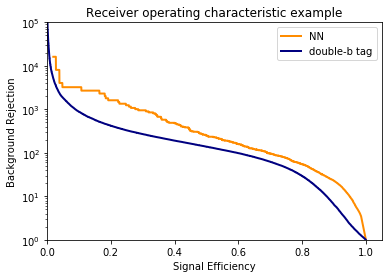

In [45]:
plt.figure()
lw = 2
plt.plot(tpr_nn, 1./fpr_nn, color='darkorange',
         lw=lw, label='NN')
plt.plot(fpr_mv2, 1./tpr_mv2, color='navy',
         lw=lw, label='double-b tag')
# plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.05])
plt.ylim([1.0, 100000])
plt.xlabel('Signal Efficiency')
plt.ylabel('Background Rejection')
plt.title('Receiver operating characteristic example')
plt.legend(loc="upper right")
plt.yscale('log')

plt.show()

In [40]:
X_all = scaler.transform(X)

In [46]:
yhat_all = model.predict(X_all, verbose = True, batch_size = 512)

5772800/5843071 [============================>.] - ETA: 0s

In [47]:
fpr_nn_all, tpr_nn_all, _ = roc_curve(y, yhat_all)

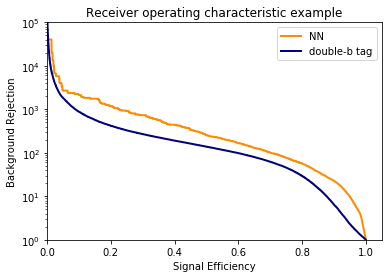

In [48]:
plt.figure()
lw = 2
plt.plot(tpr_nn_all, 1./fpr_nn_all, color='darkorange',
         lw=lw, label='NN')
plt.plot(fpr_mv2, 1./tpr_mv2, color='navy',
         lw=lw, label='double-b tag')
# plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.05])
plt.ylim([1.0, 100000])
plt.xlabel('Signal Efficiency')
plt.ylabel('Background Rejection')
plt.title('Receiver operating characteristic example')
plt.legend(loc="upper right")
plt.yscale('log')

plt.show()